# Computing Derivatives from Data

Given a time series of datapoints or measurements, it can be useful to compute the derivative of those measurements with respect to time. 

We denote the underlying function that the datapoints are samples of as $f(t)$, and assume that the samples are taken at regular time points $t_{k}$.

At a time $t_k$, we wish to use the previous measurements to compute $\dot{f}(t_k)$. These measurements are $f(t_{k-n}) ... f(t_k)$. We refer to $n$ as the order of our derivative estimator.

## Polynomial Method

One method is to approximate $f(t)$ as a polynomial spline,

$$
f(t) \approx a_0 + a_1 t + a_2 * t^2 + ... a_n * t^n
$$

In [85]:
using Symbolics, LinearAlgebra

@variables h
order = 5
steps = collect(0.0:(order - 1))
H = [((s-1.0) * -h) ^ (d - 1.0) for s = 1:order, d = 1:order]
Hinv = inv(H)
# simplify(Hinv;expand=true)

5×5 Matrix{Num}:
     1.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [86]:
Hinv1 = substitute(Hinv, Dict(h => 0.1))
[Hinv1[2,i].val for i = 1:size(H,2)]

5-element Vector{Float64}:
  20.833333333333325
 -39.99999999999998
  29.999999999999982
 -13.333333333333323
   2.499999999999998

## Finite Difference Method

In [30]:
@variables h
@variables f0, f1, f2, f3, f4, f5 # nth derivatives of f

taylor(h) = f0 + h*f1 + h^2 * f2 / factorial(2) + h^3 * f3 / factorial(3) + h^4 * f4 / factorial(4) + h^5 * f5 / factorial(5)


taylor (generic function with 1 method)

In [40]:
@variables fm1
e1 = fm1 - taylor(-h)

fm1 + f1*h + (1//120)*f5*(h^5) + (1//6)*f3*(h^3) - f0 - (1//24)*f4*(h^4) - (1//2)*f2*(h^2)

In [41]:
@variables fm2
e2 = fm2 - taylor(-2*h)

fm2 + 2f1*h + (4//15)*f5*(h^5) + (4//3)*f3*(h^3) - f0 - (2//3)*f4*(h^4) - (2//1)*f2*(h^2)

In [42]:
@variables fm3
e3 = fm3 - taylor(-3*h)

fm3 + 3f1*h + (81//40)*f5*(h^5) + (9//2)*f3*(h^3) - f0 - (27//8)*f4*(h^4) - (9//2)*f2*(h^2)

In [43]:
@variables fm4
e4 = fm4 - taylor(-4*h)

fm4 + 4f1*h + (128//15)*f5*(h^5) + (32//3)*f3*(h^3) - f0 - (8//1)*f2*(h^2) - (32//3)*f4*(h^4)

In [52]:
e12 = simplify(4*e1 - e2; expand=true)

(4//1)*fm1 + (2//1)*f1*h + (1//2)*f4*(h^4) - fm2 - (3//1)*f0 - (7//30)*f5*(h^5) - (2//3)*f3*(h^3)

In [53]:
e34 = simplify(16*e3 - 9*e4; expand=true)

(16//1)*fm3 + (12//1)*f1*h + (42//1)*f4*(h^4) - (7//1)*f0 - (9//1)*fm4 - (24//1)*f3*(h^3) - (222//5)*f5*(h^5)

In [56]:
e1234 = simplify(3*24*e12 - 2*e34; expand=true)

(18//1)*fm4 + (288//1)*fm1 + (120//1)*f1*h + (72//1)*f5*(h^5) - (32//1)*fm3 - (72//1)*fm2 - (202//1)*f0 - (48//1)*f4*(h^4)

In [60]:
simplify(e1234 * (1/120) * h^-1; expand=true)

(0.15fm4 + 2.4fm1 + f1*h + 0.6f5*(h^5) - 0.26666666666666666fm3 - 0.6fm2 - 1.6833333333333333f0 - 0.4f4*(h^4)) / h

In [72]:
f1e = Symbolics.solve_for(e1234 ~ 0, f1)

((18//1)*fm4 + (288//1)*fm1 + (72//1)*f5*(h^5) - (32//1)*fm3 - (202//1)*f0 - (72//1)*fm2 - (48//1)*f4*(h^4)) / ((-120//1)*h)

In [73]:
substitute(f1e, Dict(h => 0.1))

-0.08333333333333333(0.0007200000000000003f5 + (18//1)*fm4 + (288//1)*fm1 - (202//1)*f0 - 0.0048000000000000004f4 - (32//1)*fm3 - (72//1)*fm2)

# Testing on real B-field

In [87]:
function polynomial_derivative(buffer, f, h)
    H = [
    20.833333333333325
    -39.99999999999998
     29.999999999999982
    -13.333333333333323
      2.499999999999998
    ]

    fdot = H[1]*f + H[2]*buffer[1] + H[3]*buffer[2] + H[4]*buffer[3] + H[5]*buffer[4]

    buffer[2:4] = buffer[1:3]
    buffer[1] = f
    return fdot
end

function backward_finite_difference(buffer, f, h)
    32fm3+18fm4−202f0+288fm1−72fm2

    fdot = (-18 * buffer[4] + 32 * buffer[3] + 72 * buffer[2] - 288 * buffer[1] + 202 * f) / (120 * h)
    
    buffer[2:4] = buffer[1:3]
    buffer[1] = f
    return fdot
end


function stencil_5_point(buffer, f, h)
    fdot = (3 * buffer[4] - 16 * buffer[3] + 36 * buffer[2] - 48 * buffer[1] + 25 * f) / (12 * h)
    buffer[2:4] = buffer[1:3]
    buffer[1] = f
    return fdot
end

stencil_5_point (generic function with 1 method)

In [90]:
dt = 0.1
tspan = 0:dt:4*pi

buffer = zeros(4)
fdot_poly = [polynomial_derivative(buffer, 2*sin(t), dt) for t in tspan]
buffer = zeros(4)
fdot_fd = [backward_finite_difference(buffer, 2*sin(t), dt) for t in tspan]
buffer = zeros(4)
fdot_stencil = [stencil_5_point(buffer, 2*sin(t), dt) for t in tspan]
fdot_true = 2*cos.(tspan)

126-element Vector{Float64}:
 2.0
 1.9900083305560516
 1.9601331556824833
 1.910672978251212
 1.8421219880057702
 1.7551651237807455
 1.6506712298193564
 1.5296843745689768
 1.3934134186943308
 1.2432199365413288
 ⋮
 1.2951926773077547
 1.4408649579816775
 1.5721405922820786
 1.6877079174649843
 1.7864122230186466
 1.8672672881492758
 1.9294652357732196
 1.9723846045577274
 1.9955965583571613

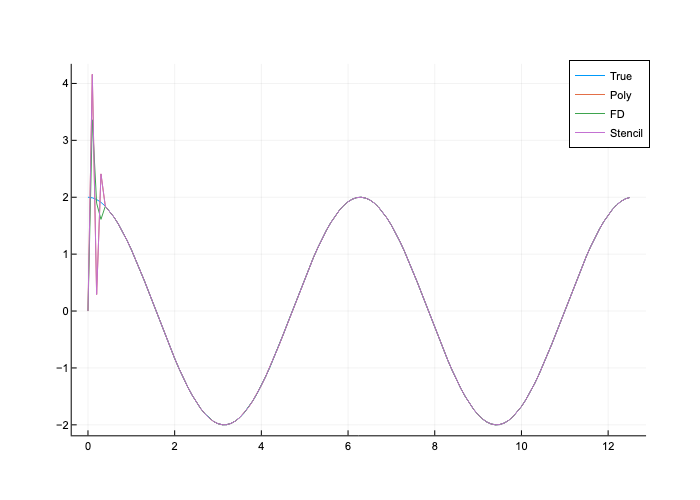

In [91]:
using Plots
plotly()

plot(tspan, fdot_true, label="True")
plot!(tspan, fdot_poly, label="Poly")
plot!(tspan, fdot_fd, label="FD")
plot!(tspan, fdot_stencil, label="Stencil")

In [92]:
fdot_poly


126-element Vector{Float64}:
 0.0
 4.159725693617838
 0.2912154513812997
 2.4098004794272763
 1.84208313374153
 1.7551273855293026
 1.6506349846488564
 1.5296499846291585
 1.3933812275981388
 1.2431902659315246
 ⋮
 1.2951722211121508
 1.4408411797213656
 1.572113729541539
 1.6876782386478437
 1.7863800246658998
 1.8672328919760397
 1.929428985454897
 1.9723468622953795
 1.9955577012590542

In [93]:
fdot_stencil

126-element Vector{Float64}:
 0.0
 4.159725693617839
 0.29121545138129845
 2.409800479427275
 1.842083133741526
 1.7551273855293024
 1.650634984648853
 1.5296499846291605
 1.3933812275981219
 1.2431902659315182
 ⋮
 1.2951722211121521
 1.4408411797213814
 1.5721137295415457
 1.6876782386478426
 1.7863800246659134
 1.8672328919760426
 1.9294289854548963
 1.9723468622953841
 1.9955577012590553